# Libraries

In [188]:
# Basic

import os
import warnings
import re
import pickle
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

# Clustering

from sklearn.cluster import KMeans

# ANN

from keras.models import Sequential
from keras.layers import Dense

# Supervised ML

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV as GSCV

# Optional

warnings.filterwarnings('ignore')

# Dataset

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Initial Checks

In [3]:
def initialPrep(df):
    df.columns = df.columns.str.lower() # To make it easier to call the columns
    if df.duplicated().sum() != 0:
        print('Shape of the dataset before deleting the duplicated rows', df.shape)
        print('Number of duplicated rows in the dataset', df.duplicated().sum())
        df = df.drop_duplicates()
        print('Shape of the dataset after deleting the duplicated rows', df.shape)
    else:
        print('There are no Duplicated Rows in the dataset!')
        print('Shape of the dataset', df.shape)
        
    m = list(df_train.isnull().sum())
    global nul_var
    nul_var = []
    for index, i in enumerate(m):
        if i != 0:
           nul_var.append(df_train.columns[index])
        else:
            pass

In [4]:
# Calling the Function

initialPrep(df_train)

There are no Duplicated Rows in the dataset!
Shape of the dataset (7007, 23)


In [5]:
# Calling the Function

initialPrep(df_test)

There are no Duplicated Rows in the dataset!
Shape of the dataset (2093, 22)


# Basic Data Exploration

In [6]:
# Variable Seperation based on the given description and the number of uniques values

drop_col = ['deal_title', 'lead_name', 'contact_no', 'poc_name', 'lead_poc_email', 'internal_poc']

quant_col = ['deal_value']

cat_col = ['industry', 'pitch', 'fund_category', 'geography', 'location', 'designation', 
          'hiring_candidate_role', 'lead_source', 'level_of_meeting', 'last_lead_update', 
          'resource', 'internal_rating']

fur_pro = ['weighted_amount', 'date_of_creation', 'lead_revenue']

tar_var = ['success_probability']

### Working on the Variables with the need of Further processing

In [7]:
# Removing the Dollar sign from 'weighted_amount'

for i in range(len(df_train['weighted_amount'])):
    if df_train['weighted_amount'][[i]].isnull().values == True:
        pass
    else:
        a = str(df_train['weighted_amount'][i]).split('$')
        df_train['weighted_amount'][i] = a[0]
        
# Changing the type of the Variable

df_train['weighted_amount']= df_train['weighted_amount'].astype('float64')

# Converting 'date_of_creation' column into Date tyoe

df_train['date_of_creation'] = pd.to_datetime(df_train['date_of_creation'],
                                             format = '%Y-%m-%d')

# Converting 'lead_revenue' variable into a categorical one

df_train['lead_revenue'] = pd.Categorical(df_train['lead_revenue'],
                                         ['50 - 100 Million', '100 - 500 Million','500 Million - 1 Billion'],
                                         ordered = True)
df_train['lead_revenue'] = df_train['lead_revenue'].cat.codes

################### Updated Variables ##############################

# Variable Seperation based on the given description and the number of uniques values

drop_col = ['deal_title', 'lead_name', 'contact_no', 'poc_name', 'lead_poc_email', 'internal_poc']

quant_col = ['deal_value', 'weighted_amount']

cat_col = ['industry', 'pitch', 'fund_category', 'geography', 'location', 'designation', 
          'hiring_candidate_role', 'lead_source', 'level_of_meeting', 'last_lead_update', 
          'resource', 'internal_rating', 'date_of_creation', 'lead_revenue']

tar_var = ['success_probability']

# Feature Engineering

In [8]:
# Removing '$' from the columns

for i in range(len(df_train['deal_value'])):
    if df_train['deal_value'][[i]].isnull().values == True:
        pass
    else:
        a = str(df_train['deal_value'][i]).split('$')
        df_train['deal_value'][i] = a[0]

# Converting 'pitch' variable into Categorical Variable

df_train['pitch'] = pd.Categorical(df_train['pitch'],
                                  ['Product_2', 'Product_1'], 
                                   ordered = True)

df_train['pitch'] = df_train['pitch'].cat.codes

# Making the 'resource' into only 2 uniques

df_train['resource'].replace({'Not enough':'No','Cannot deliver':'No',
                             'Deliverable':'Yes', 'We have all the requirements':'Yes'},
                            inplace = True)


# Converting '?' with NaN value

df_train['last_lead_update'].replace({'?':np.nan}, inplace = True)


# Converting 'level_of_meeting' into Categorical Variable

df_train['level_of_meeting'] = pd.Categorical(df_train['level_of_meeting'],
                                             ['Level 1', 'Level 2','Level 3'],
                                             ordered = True)

df_train['level_of_meeting'] = df_train['level_of_meeting'].cat.codes

# Converting 'lead_source' into Categorical Variable

df_train['lead_source'] = pd.Categorical(df_train['lead_source'],
                                             ['Website', 'Others', 'Marketing Event', 'Contact Email'],
                                             ordered = False)

# Converting 'fund_category' into Categorical Variable

df_train['fund_category'] = pd.Categorical(df_train['fund_category'],
                                             ['Category 1','Category 2','Category 3','Category 4'],
                                             ordered = True)

df_train['fund_category'] = df_train['fund_category'].cat.codes

# Missing Value Treatment

In [9]:
# Determining the Variables with Missing Values (Percentage-basis)
np.round((((df_train[nul_var].isnull().sum())/len(df_train))*100),2)

industry             0.01
deal_value           0.73
weighted_amount      7.49
geography           13.87
location             0.16
poc_name             0.11
last_lead_update    17.38
resource             2.13
dtype: float64

**Missing Value Treatment Approach**

1. Variables with less than 10% of missing values - Simply imputed by Mode or Median, depending on the type of variable.

2. Variables with more than 10% and less than 30% of the missing values - Imputations are based on the correlation with other variables.

3. Variables with equal or more than 30% of the missing values - Variable(s) dropped. 

In [10]:
# Treating Missing Values of 'industry' with Mode

df_train['industry'].fillna(df_train['industry'].mode()[0],inplace=True)

# 'industry' variable transformation into Categorical

df_train['industry'] = pd.Categorical(df_train['industry'],
                                     df_train['industry'].unique(),
                                     ordered = False)

# Treating Missing Values of 'weighted_amount' with Median

df_train['weighted_amount'].fillna(np.round(df_train['weighted_amount'].median(),2),
                                  inplace = True)

# Treating Missing Values of 'location'  with Mode Value depending on the Values of 'geography' variable

for i in range(len(df_train['location'])):
    if df_train['location'][[i]].isnull().values == True:
        if df_train['geography'][i] == 'USA':
            df_train['location'][i] = df_train['location'][df_train['geography'] =='USA'].mode()[0]
        elif df_train['geography'][i] == 'India':
            df_train['location'][i] = df_train['location'][df_train['geography'] =='India'].mode()[0]
        else:
            df_train['location'][i] = df_train['location'].mode()[0]
    else:
        pass
    
# Treating Missing Values of 'geography' on the basis of values of 'location' variable

us_locations = list(df_train['location'][df_train['geography'] =='USA'].unique())
ind_locations = list(df_train['location'][df_train['geography'] =='India'].unique())

for i in range(len(df_train['geography'])):
    if df_train['geography'][[i]].isnull().values == True:
        if df_train['location'][i] in us_locations:
            df_train['geography'][i] = 'USA'
        else:
            df_train['geography'][i] = 'India'
    else:
        pass
    
# Treating Missing Values of 'last_lead_update' on the basis of values of 'geography'

for i in range(len(df_train['last_lead_update'])):
    if (df_train['last_lead_update'][[i]].isnull().values == True) and (df_train['geography'][i] == 'India'):
        df_train['last_lead_update'][i] = df_train['last_lead_update'][df_train['geography'] == 'India'].mode()[0]
    elif (df_train['last_lead_update'][[i]].isnull().values == True) and (df_train['geography'][i] == 'USA'):
        df_train['last_lead_update'][i] = df_train['last_lead_update'][df_train['geography'] == 'USA'].mode()[0]
    else:
        pass
    
    
# Imputing Missing Values of 'deal_value' with Median Value

df_train['deal_value'].fillna(np.round(df_train['deal_value'].median(),2), inplace=True)

# Imputing Missing Values for 'resource' with Mode

df_train['resource'].fillna(df_train['resource'].mode()[0], inplace = True)

# Feature Engineering (Further)

In [11]:
# Transforming the dtypes of the variables accordingly

df_train['deal_value'] = df_train['deal_value'].astype('int64') # from float

df_train['geography'] = pd.Categorical(df_train['geography'], 
                                      ['India', 'USA'],
                                      ordered = True)

df_train['geography'] = df_train['geography'].cat.codes

df_train['location'] = pd.Categorical(df_train['location'], 
                                      df_train['location'].unique(),
                                      ordered = False)

df_train['designation'] = pd.Categorical(df_train['designation'], 
                                      df_train['designation'].unique(),
                                      ordered = False)

df_train['hiring_candidate_role'] = pd.Categorical(df_train['hiring_candidate_role'], 
                                      df_train['hiring_candidate_role'].unique(),
                                      ordered = False)



df_train['resource'] = pd.Categorical(df_train['resource'],
                                  ['No','Yes'], 
                                   ordered = True)

df_train['resource'] = df_train['resource'].cat.codes

df_train['lead_source'] = pd.Categorical(df_train['lead_source'],
                                  ['Website','Others','Contact Email','Marketing Event'], 
                                   ordered = True)

df_train['lead_source'] = df_train['lead_source'].cat.codes

df_train['last_lead_update'] = pd.Categorical(df_train['last_lead_update'],
                                  ['Pending','Did not hear back after Level 1','More than a week back',
                                   'More than 2 weeks', '2 days back', '5 days back', 'No track',
                                  'more than a month', 'Up-to-date', 'Following up but lead not responding'], 
                                   ordered = True)

df_train['last_lead_update'] = df_train['last_lead_update'].cat.codes

# Extracting Months and Year from Date Predictor

df_train['year_of_creation'] = df_train['date_of_creation'].dt.year
df_train['month_of_creation'] = df_train['date_of_creation'].dt.month

df_train['high_month'] = pd.Categorical(df_train['month_of_creation'],
                                       [4,7,9,2,11,8,1,12,6,10,5,3],
                                       ordered = True)

df_train['high_month'] = df_train['high_month'].cat.codes

df_train['high_year'] = pd.Categorical(df_train['year_of_creation'], [2019,2021,2020], ordered = True)

df_train['high_year'] = df_train['high_year'].cat.codes

In [ ]:
df_train.info()

In [12]:
################### Updated Variables ##############################

# Variable Seperation based on the given description and the number of uniques values

drop_col = ['deal_title', 'lead_name', 'contact_no', 'poc_name', 'lead_poc_email', 'internal_poc',
           'month_of_creation', 'year_of_creation']

quant_col = ['deal_value', 'weighted_amount','success_probability']

cat_col = ['industry', 'pitch', 'fund_category', 'geography', 'location', 'designation', 
          'hiring_candidate_role', 'lead_source', 'level_of_meeting', 'last_lead_update', 
          'resource', 'internal_rating', 'date_of_creation', 'lead_revenue', 'high_year',
          'high_month']

# Clustering

In [13]:
df_train.columns

Index(['deal_title', 'lead_name', 'industry', 'deal_value', 'weighted_amount',
       'date_of_creation', 'pitch', 'contact_no', 'lead_revenue',
       'fund_category', 'geography', 'location', 'poc_name', 'designation',
       'lead_poc_email', 'hiring_candidate_role', 'lead_source',
       'level_of_meeting', 'last_lead_update', 'internal_poc', 'resource',
       'internal_rating', 'success_probability', 'year_of_creation',
       'month_of_creation', 'high_month', 'high_year'],
      dtype='object')

In [45]:
Data_cluster = df_train[['industry','pitch','deal_value']]

Data_cluster.head()

,industry,pitch,deal_value
0,Restaurants,0,320506
1,Construction Services,0,39488
2,Hospitals/Clinics,1,359392
3,Real Estate,0,76774
4,Financial Services,0,483896


In [46]:
# Converting str type variable into int type

Data_cluster['industry'] = pd.Categorical(Data_cluster['industry'],
                                           Data_cluster['industry'].unique(), ordered = False)

Data_cluster['industry'] = Data_cluster['industry'].cat.codes

# Confirming the Change

Data_cluster.head()

,industry,pitch,deal_value
0,0,0,320506
1,1,0,39488
2,2,1,359392
3,3,0,76774
4,4,0,483896


In [47]:
X_clust = Data_cluster.values

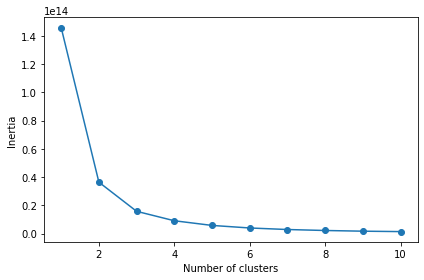

In [48]:
# Finding the best number of clusters

inertiaValue = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='random',
                n_init=10, 
                max_iter=300,
                tol=1e-04,
                random_state=0)
    
    km.fit(X_clust)
    inertiaValue.append(km.inertia_)
    
plt.plot(range(1, 11), inertiaValue, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

Optimum number of clusters chosen is 3.

In [49]:
km = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=3)

predictedCluster = km.fit_predict(X_clust)

df_train['ClusterID'] = predictedCluster

# Outlier Handling

<AxesSubplot:xlabel='success_probability'>

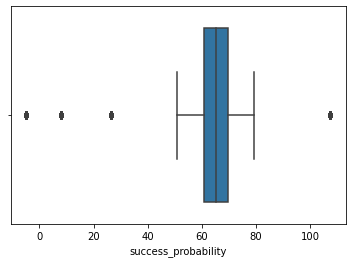

In [36]:
# For Target Variable

sns.boxplot(df_train['success_probability'])

<AxesSubplot:xlabel='success_probability'>

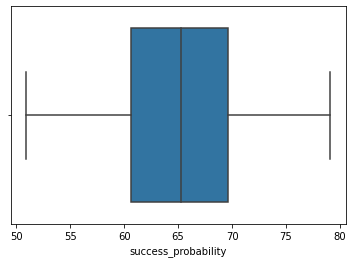

In [37]:
# Probability values below 0 and over 100 to be replaced by their respective nearest logical values

df_train['success_probability'][df_train['success_probability']>80] = 79.1
df_train['success_probability'][df_train['success_probability']<51] = 50.9

# Distribution After Outlier handling

sns.boxplot(df_train['success_probability'])

### For Quantitative Predictors

There is no presence of outliers in the quantitative variables.

# Visualization of Categorical Variables

In [38]:
################### Updated Variables ##############################

# Variable Seperation based on the given description and the number of uniques values

drop_col = ['deal_title', 'lead_name', 'contact_no', 'poc_name', 'lead_poc_email', 'internal_poc',
           'month_of_creation', 'year_of_creation']

quant_col = ['deal_value', 'weighted_amount','success_probability']

cat_col = ['industry', 'pitch', 'fund_category', 'geography', 'location', 'designation', 
          'hiring_candidate_role', 'lead_source', 'level_of_meeting', 'last_lead_update', 
          'resource', 'internal_rating', 'date_of_creation', 'lead_revenue', 'high_year',
          'high_month','ClusterID']

In [39]:
def PlotBarCharts(inpData, colsToPlot):
    fig, subPlot = plt.subplots(nrows=1, ncols = len(colsToPlot), figsize=(20,10))
    fig.suptitle('Bar Charts of:' + str(colsToPlot))
    
    for colName, plotNumber in zip(colsToPlot, range(len(colsToPlot))):
        inpData.groupby(colName).size().plot(kind='bar', ax=subPlot[plotNumber])

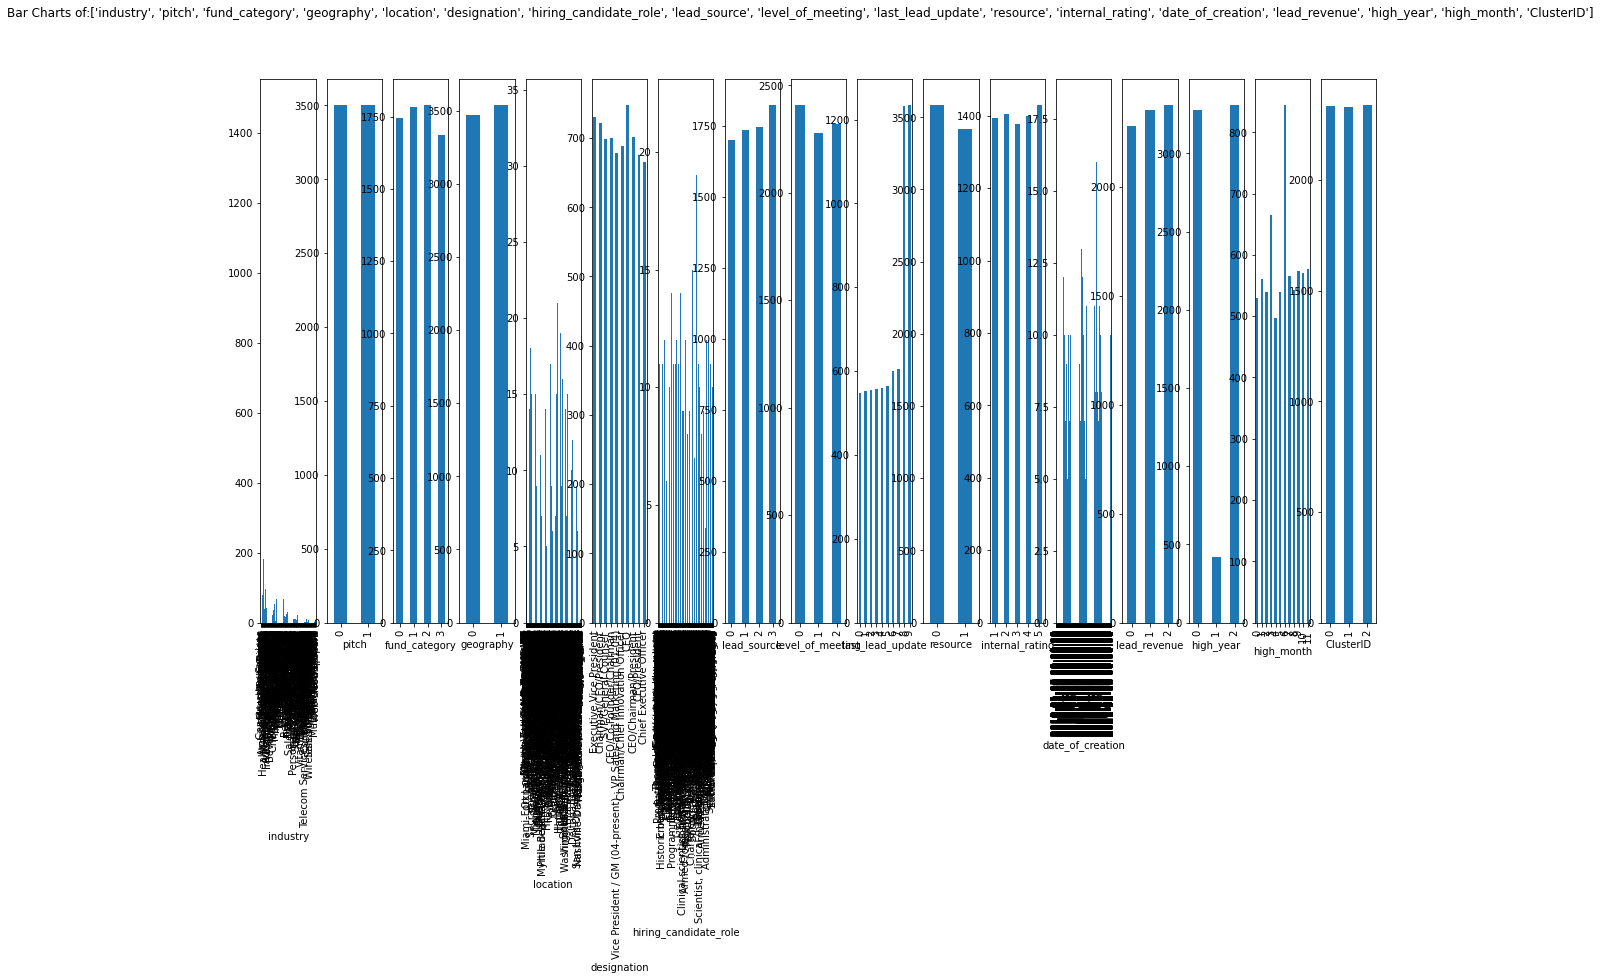

In [40]:
PlotBarCharts(inpData = df_train,
             colsToPlot = cat_col)

**OUTCOME OF THE VISUALIZATION**

* All the categorical predictors seem to have enough variations.

# Statistical Feature Selection

### Correlation Matrix

In [41]:
df_train[quant_col].corr()

,deal_value,weighted_amount,success_probability
deal_value,1.000000,0.949448,0.071332
weighted_amount,0.949448,1.000000,0.110680
success_probability,0.071332,0.110680,1.000000


**OUTCOME OF CORRELATION MATRIX**

* All the continuous predictors are correlated to the Target Variable.

### ANOVA Test

In [42]:
def FunctionAnova(inpData, TargetVariable, CategoricalPredictorList):

    # Creating an empty list of final selected predictors
    SelectedPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in CategoricalPredictorList:
        CategoryGroupLists=inpData.groupby(predictor)[TargetVariable].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
    
    return(SelectedPredictors)

In [50]:
FunctionAnova(inpData=df_train, 
              TargetVariable='success_probability', 
              CategoricalPredictorList=cat_col)

##### ANOVA Results ##### 

industry is NOT correlated with success_probability | P-Value: 0.8247151359167761
pitch is NOT correlated with success_probability | P-Value: 0.7611664312707982
fund_category is correlated with success_probability | P-Value: 5.19933819199865e-35
geography is correlated with success_probability | P-Value: 5.369275551753162e-299
location is correlated with success_probability | P-Value: 1.9706486121001607e-138
designation is NOT correlated with success_probability | P-Value: 0.9784411703932591
hiring_candidate_role is NOT correlated with success_probability | P-Value: 0.9077206134804474
lead_source is correlated with success_probability | P-Value: 1.2253594226487545e-38
level_of_meeting is correlated with success_probability | P-Value: 6.820088138566349e-78
last_lead_update is correlated with success_probability | P-Value: 7.136512614646e-21
resource is NOT correlated with success_probability | P-Value: 0.7964133159211657
internal_rating is correlated with suc

['fund_category',
 'geography',
 'location',
 'lead_source',
 'level_of_meeting',
 'last_lead_update',
 'internal_rating',
 'lead_revenue',
 'ClusterID']

# Selecting Final Predictors for Model

In [51]:
SelectedColumns = ['fund_category','geography', 'location', 'lead_source', 'level_of_meeting',
                   'last_lead_update', 'internal_rating','lead_revenue', 'deal_value',
                   'weighted_amount','ClusterID']

DataForML = df_train[SelectedColumns]

# Exporting for Future Reference

DataForML.to_pickle('DataForML_2.pkl')

# Data Pre-processing for ML

In [53]:
# Re-checking if any of the selected columns are non-numeric

DataForML.head(2)

,fund_category,geography,location,lead_source,level_of_meeting,last_lead_update,internal_rating,lead_revenue,deal_value,weighted_amount,ClusterID
0,1,1,"Killeen-Temple, TX",0,2,6,3,0,320506,2067263.7,2
1,3,0,Ratlam,1,0,1,5,2,39488,240876.8,0


In [55]:
# Creating a new Data frame with only numeric values

DataForML_Numeric = pd.DataFrame()

DataForML_Numeric['fund_category'] = DataForML['fund_category']
DataForML_Numeric['geography'] = DataForML['geography']
DataForML_Numeric['location'] = DataForML['location'].cat.codes
DataForML_Numeric['lead_source'] = DataForML['lead_source']
DataForML_Numeric['level_of_meeting'] = DataForML['level_of_meeting']
DataForML_Numeric['last_lead_update'] = DataForML['last_lead_update']
DataForML_Numeric['internal_rating'] = DataForML['internal_rating']
DataForML_Numeric['lead_revenue'] = DataForML['lead_revenue']
DataForML_Numeric['deal_value'] = DataForML['deal_value']
DataForML_Numeric['weighted_amount'] = DataForML['weighted_amount']
DataForML_Numeric['ClusterID'] = DataForML['ClusterID']

# Adding Target Varibale
DataForML_Numeric['success_probability'] = df_train['success_probability']

# Confirming the Changes

DataForML_Numeric.head(2)

,fund_category,geography,location,lead_source,level_of_meeting,last_lead_update,internal_rating,lead_revenue,deal_value,weighted_amount,ClusterID,success_probability
0,1,1,0,0,2,6,3,0,320506,2067263.7,2,73.6
1,3,0,1,1,0,1,5,2,39488,240876.8,0,58.9


In [60]:
print('The Shape of the Working Data-Frame is: ',DataForML_Numeric.shape, end='\n')
print('The Reduction in the number of Columns from original Data-Frame is: ', (df_train.shape[1]-DataForML_Numeric.shape[1]))

The Shape of the Working Data-Frame is:  (7007, 12)
The Reduction in the number of Columns from original Data-Frame is:  16


# Processing Testing Data in line with the Training Data

In [63]:
df_test1 = pd.read_csv('test.csv')

In [65]:
# Removing the Dollar sign from 'weighted_amount'

for i in range(len(df_test['weighted_amount'])):
    if df_test['weighted_amount'][[i]].isnull().values == True:
        pass
    else:
        a = str(df_test['weighted_amount'][i]).split('$')
        df_test['weighted_amount'][i] = a[0]
        
# Changing the type of the Variable

df_test['weighted_amount']= df_test['weighted_amount'].astype('float64')

# Converting 'date_of_creation' column into Date tyoe

df_test['date_of_creation'] = pd.to_datetime(df_test['date_of_creation'],
                                             format = '%Y-%m-%d')

# Converting 'lead_revenue' variable into a categorical one

df_test['lead_revenue'] = pd.Categorical(df_test['lead_revenue'],
                                         ['50 - 100 Million', '100 - 500 Million','500 Million - 1 Billion'],
                                         ordered = True)
df_test['lead_revenue'] = df_test['lead_revenue'].cat.codes

# Removing '$' from the columns

for i in range(len(df_test['deal_value'])):
    if df_test['deal_value'][[i]].isnull().values == True:
        pass
    else:
        a = str(df_test['deal_value'][i]).split('$')
        df_test['deal_value'][i] = a[0]

# Converting 'pitch' variable into Categorical Variable

df_test['pitch'] = pd.Categorical(df_test['pitch'],
                                  ['Product_2', 'Product_1'], 
                                   ordered = True)

df_test['pitch'] = df_test['pitch'].cat.codes

# Making the 'resource' into only 2 uniques

df_test['resource'].replace({'Not enough':'No','Cannot deliver':'No',
                             'Deliverable':'Yes', 'We have all the requirements':'Yes'},
                            inplace = True)


# Converting '?' with NaN value

df_test['last_lead_update'].replace({'?':np.nan}, inplace = True)


# Converting 'level_of_meeting' into Categorical Variable

df_test['level_of_meeting'] = pd.Categorical(df_test['level_of_meeting'],
                                             ['Level 1', 'Level 2','Level 3'],
                                             ordered = True)

df_test['level_of_meeting'] = df_test['level_of_meeting'].cat.codes

# Converting 'lead_source' into Categorical Variable

df_test['lead_source'] = pd.Categorical(df_test['lead_source'],
                                             ['Website', 'Others', 'Marketing Event', 'Contact Email'],
                                             ordered = False)

# Converting 'fund_category' into Categorical Variable

df_test['fund_category'] = pd.Categorical(df_test['fund_category'],
                                             ['Category 1','Category 2','Category 3','Category 4'],
                                             ordered = True)

df_test['fund_category'] = df_test['fund_category'].cat.codes

# Treating Missing Values of 'industry' with Mode

df_test['industry'].fillna(df_test['industry'].mode()[0],inplace=True)

# 'industry' variable transformation into Categorical

df_test['industry'] = pd.Categorical(df_test['industry'],
                                     df_test['industry'].unique(),
                                     ordered = False)

# Treating Missing Values of 'weighted_amount' with Median

df_test['weighted_amount'].fillna(np.round(df_test['weighted_amount'].median(),2),
                                  inplace = True)

# Treating Missing Values of 'location'  with Mode Value depending on the Values of 'geography' variable

for i in range(len(df_test['location'])):
    if df_test['location'][[i]].isnull().values == True:
        if df_test['geography'][i] == 'USA':
            df_test['location'][i] = df_test['location'][df_test['geography'] =='USA'].mode()[0]
        elif df_test['geography'][i] == 'India':
            df_test['location'][i] = df_test['location'][df_test['geography'] =='India'].mode()[0]
        else:
            df_test['location'][i] = df_test['location'].mode()[0]
    else:
        pass
    
# Treating Missing Values of 'geography' on the basis of values of 'location' variable

us_locations = list(df_test['location'][df_test['geography'] =='USA'].unique())
ind_locations = list(df_test['location'][df_test['geography'] =='India'].unique())

for i in range(len(df_test['geography'])):
    if df_test['geography'][[i]].isnull().values == True:
        if df_test['location'][i] in us_locations:
            df_test['geography'][i] = 'USA'
        else:
            df_test['geography'][i] = 'India'
    else:
        pass
    
# Treating Missing Values of 'last_lead_update' on the basis of values of 'geography'

for i in range(len(df_test['last_lead_update'])):
    if (df_test['last_lead_update'][[i]].isnull().values == True) and (df_test['geography'][i] == 'India'):
        df_test['last_lead_update'][i] = df_test['last_lead_update'][df_test['geography'] == 'India'].mode()[0]
    elif (df_test['last_lead_update'][[i]].isnull().values == True) and (df_test['geography'][i] == 'USA'):
        df_test['last_lead_update'][i] = df_test['last_lead_update'][df_test['geography'] == 'USA'].mode()[0]
    else:
        pass
    
    
# Imputing Missing Values of 'deal_value' with Median Value

df_test['deal_value'].fillna(np.round(df_test['deal_value'].median(),2), inplace=True)

# Imputing Missing Values for 'resource' with Mode

df_test['resource'].fillna(df_test['resource'].mode()[0], inplace = True)

# Transforming the dtypes of the variables accordingly

df_test['deal_value'] = df_test['deal_value'].astype('int64') # from float

df_test['geography'] = pd.Categorical(df_test['geography'], 
                                      ['India', 'USA'],
                                      ordered = True)

df_test['geography'] = df_test['geography'].cat.codes

df_test['location'] = pd.Categorical(df_test['location'], 
                                      df_test['location'].unique(),
                                      ordered = False)

df_test['designation'] = pd.Categorical(df_test['designation'], 
                                      df_test['designation'].unique(),
                                      ordered = False)

df_test['hiring_candidate_role'] = pd.Categorical(df_test['hiring_candidate_role'], 
                                      df_test['hiring_candidate_role'].unique(),
                                      ordered = False)



df_test['resource'] = pd.Categorical(df_test['resource'],
                                  ['No','Yes'], 
                                   ordered = True)

df_test['resource'] = df_test['resource'].cat.codes

df_test['lead_source'] = pd.Categorical(df_test['lead_source'],
                                  ['Website','Others','Contact Email','Marketing Event'], 
                                   ordered = True)

df_test['lead_source'] = df_test['lead_source'].cat.codes

df_test['last_lead_update'] = pd.Categorical(df_test['last_lead_update'],
                                  ['Pending','Did not hear back after Level 1','More than a week back',
                                   'More than 2 weeks', '2 days back', '5 days back', 'No track',
                                  'more than a month', 'Up-to-date', 'Following up but lead not responding'], 
                                   ordered = True)

df_test['last_lead_update'] = df_test['last_lead_update'].cat.codes

# Extracting Months and Year from Date Predictor

df_test['year_of_creation'] = df_test['date_of_creation'].dt.year
df_test['month_of_creation'] = df_test['date_of_creation'].dt.month

df_test['high_month'] = pd.Categorical(df_test['month_of_creation'],
                                       [4,7,9,2,11,8,1,12,6,10,5,3],
                                       ordered = True)

df_test['high_month'] = df_test['high_month'].cat.codes

df_test['high_year'] = pd.Categorical(df_test['year_of_creation'], [2019,2021,2020], ordered = True)

df_test['high_year'] = df_test['high_year'].cat.codes

Data_cluster1 = df_test[['industry','pitch','deal_value']]

# Converting str type variable into int type

Data_cluster1['industry'] = pd.Categorical(Data_cluster1['industry'],
                                           Data_cluster1['industry'].unique(), ordered = False)

Data_cluster1['industry'] = Data_cluster1['industry'].cat.codes

X_clust1 = Data_cluster1.values

km = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=3)

predictedCluster1 = km.fit_predict(X_clust1)

df_test['ClusterID'] = predictedCluster1

df_test['location'] = df_test['location'].cat.codes

# Scaling the Training Data

In [68]:
DataForML_Numeric.columns

Index(['fund_category', 'geography', 'location', 'lead_source',
       'level_of_meeting', 'last_lead_update', 'internal_rating',
       'lead_revenue', 'deal_value', 'weighted_amount', 'ClusterID',
       'success_probability'],
      dtype='object')

In [69]:
TargetVariable = 'success_probability'
Predictors = ['fund_category', 'geography', 'location', 'lead_source','level_of_meeting',
              'last_lead_update', 'internal_rating','lead_revenue', 'deal_value', 'weighted_amount',
              'ClusterID']

X=DataForML_Numeric[Predictors].values
y=DataForML_Numeric[TargetVariable].values

PredictorScaler = MinMaxScaler()
PredictorScalerFit = PredictorScaler.fit(X)
X = PredictorScalerFit.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4904, 11)
(4904,)
(2103, 11)
(2103,)


In [70]:
# On Test Data

df_test = df_test[Predictors].values

PredictorScaler = MinMaxScaler()
PredictorScalerFit = PredictorScaler.fit(df_test)
df_test_scaled = PredictorScalerFit.transform(df_test)

# ANN

In [161]:
model = Sequential()

model.add(Dense(units=7, input_dim=11, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=6, kernel_initializer='normal', activation='relu'))
#model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
model.add(Dense(units=4, kernel_initializer='normal', activation='tanh'))
model.add(Dense(units=3, kernel_initializer='normal', activation='tanh'))
model.add(Dense(units=2, kernel_initializer='normal', activation='relu'))

model.add(Dense(1, kernel_initializer='normal',activation='relu'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [162]:
# Fitting

model.fit(X_train, y_train ,batch_size = 20, epochs = 50, verbose=1)

Epoch 1/50
246/246 [==============================] - 0s 883us/step - loss: 4209.9058
Epoch 2/50
246/246 [==============================] - 0s 901us/step - loss: 3804.4478
Epoch 3/50
246/246 [==============================] - 0s 852us/step - loss: 3179.6321
Epoch 4/50
246/246 [==============================] - 0s 684us/step - loss: 2452.0361
Epoch 5/50
246/246 [==============================] - 0s 782us/step - loss: 1731.0624
Epoch 6/50
246/246 [==============================] - 0s 751us/step - loss: 1108.0216
Epoch 7/50
246/246 [==============================] - 0s 699us/step - loss: 636.9412
Epoch 8/50
246/246 [==============================] - 0s 744us/step - loss: 330.4280
Epoch 9/50
246/246 [==============================] - 0s 733us/step - loss: 162.7262
Epoch 10/50
246/246 [==============================] - 0s 716us/step - loss: 87.6222
Epoch 11/50
246/246 [==============================] - 0s 737us/step - loss: 61.0769
Epoch 12/50
246/246 [==============================] - 0s 7

# Finding Best Set of Parameters

In [163]:
def FindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5,10,15,20]
    epoch_list  =   [5, 10, 50, 100]
    
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            model = Sequential()

            model.add(Dense(units=7, input_dim=11, kernel_initializer='normal', activation='relu'))
            model.add(Dense(units=6, kernel_initializer='normal', activation='relu'))
            #model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
            model.add(Dense(units=4, kernel_initializer='normal', activation='tanh'))
            model.add(Dense(units=3, kernel_initializer='normal', activation='tanh'))
            model.add(Dense(units=2, kernel_initializer='normal', activation='relu'))

            model.add(Dense(1, kernel_initializer='normal',activation='relu'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = 10, verbose=0)

            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)

In [164]:
ResultsData=FindBestParams(X_train, y_train, X_test, y_test)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 89.70282098205229
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 89.87350900717644
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 0.0
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 89.94705375369439
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 90.8641326832417
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 90.86030328581734
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.0
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 0.0
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 90.86885737475914
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.0
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 90.87134384189665
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 0.0
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.0
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 89.6816944565141
15 Parameters: batch_size: 20 - epochs: 50 Accuracy: 68.61677013809141
16 Parameters: batch_size: 20 - epo

<AxesSubplot:xlabel='Parameters'>

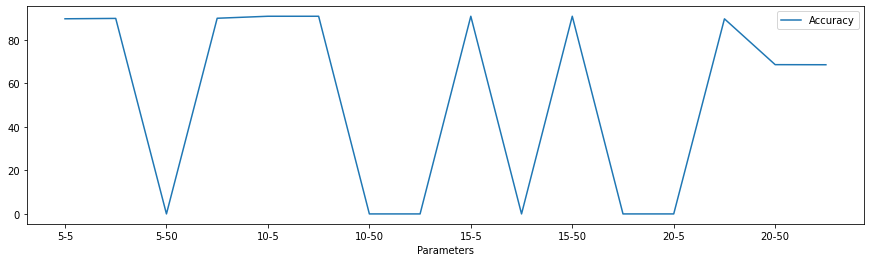

In [165]:
%matplotlib inline
ResultsData.plot(x='Parameters', y='Accuracy', figsize=(15,4), kind='line')

# Generating the Model using best hyperparameters

In [168]:
model.fit(X_train, y_train ,batch_size = 5, epochs = 10, verbose=0)

# Generating Predictions

In [169]:
# Predictions on testing data
Predictions=model.predict(df_test_scaled)


TestingData=pd.DataFrame()
TestingData['Deal_title'] = df_test1['Deal_title']
TestingData['Success_probability']=Predictions

### Exporting Predictions
TestingData.to_csv('Market_Waste_2.csv')

# Supervised ML

In [180]:
def RegBase(X_train,y_train,X_test,y_test):
    Algo_list = [KNeighborsRegressor, XGBRegressor, AdaBoostRegressor, RandomForestRegressor,
                DecisionTreeRegressor, LinearRegression, SVR]
    cust_scores = {}
    for Regressor in Algo_list:
        reg = Regressor()
        REG = reg.fit(X_train,y_train)
        prediction = REG.predict(X_test)
        score = max(0, 100 - np.sqrt(metrics.mean_squared_error(y_test,prediction)))
        cust_scores.update({Regressor:round(score,2)})
        
    return cust_scores

In [181]:
# Determining Baseline Scoring

RegBase(X_train,y_train,X_test,y_test)

{sklearn.neighbors._regression.KNeighborsRegressor: 93.47,
 xgboost.sklearn.XGBRegressor: 93.54,
 sklearn.ensemble._weight_boosting.AdaBoostRegressor: 92.97,
 sklearn.ensemble._forest.RandomForestRegressor: 93.68,
 sklearn.tree._classes.DecisionTreeRegressor: 90.96,
 sklearn.linear_model._base.LinearRegression: 93.89,
 sklearn.svm._classes.SVR: 93.98}

From the baseline scoring, it could be seen that 5 algorithms have almost similar scores. The chosen algorithms are:

* KNN Regressor
* XGB Regressor
* Support Vector Regressor
* RandomForest Regressor
* Linear Regressor

**Plan of Action**

* Determining Best Hyperparameter values for each of the Algorithm.
* Performing Cross-Validation on the algorithms using the tuned hyper-parameters.
* The one with the best score, will be used for making predictions.

# Hyper-parameter Tuning

In [178]:
Target_Var = ['success_probability']
Predictor_Var = ['fund_category', 'geography', 'location', 'lead_source','level_of_meeting',
                 'last_lead_update', 'internal_rating','lead_revenue', 'deal_value',
                 'weighted_amount', 'ClusterID']

In [184]:

# For Linear Regression

param_grid = {
    'fit_intercept' : ('True','False'),
    'normalize' : ('True','False'),
    'positive' : ('True', 'False')
}

grid = GSCV(LinearRegression(), param_grid)
grid.fit(DataForML_Numeric[Predictor_Var],DataForML_Numeric[Target_Var])

print('Recommended parameters for Linear Regressor are: ', grid.best_params_)

# For Random Forest Regressor

param_grid = {
    'n_estimators' : [20,50,70],
    'criterion' : ('mse', 'mae'),
    'max_features' : ('auto', 'sqrt', 'log2')
}

grid = GSCV(RandomForestRegressor(), param_grid)
grid.fit(DataForML_Numeric[Predictor_Var],DataForML_Numeric[Target_Var])

print('Recommended parameters for RF Regressor are: ', grid.best_params_)


# XGB Regressor

param_grid = {
    'learning_rate' : [0.2,0.4,0.6],
    'max_depth' : [20,30,40],
    'min_child_weight' : [2,4,6],
    'gamma' : [0.2,0.4,0.6]
}

grid = GSCV(XGBRegressor(), param_grid)
grid.fit(DataForML_Numeric[Predictor_Var],DataForML_Numeric[Target_Var])

print('Recommended parameters for XGB Regressor are: ', grid.best_params_)

# KNN Regressor

param_grid = {
    'n_neighbors' : [20,30,40],
    'weights' : ('uniform', 'distance'),
    'algorithm' : ('auto', 'ball_tree', 'kd_tree', 'brute'),
    'p' : range(1,3)
}

grid = GSCV(KNeighborsRegressor(), param_grid)
grid.fit(DataForML_Numeric[Predictor_Var],DataForML_Numeric[Target_Var])

print('Recommended parameters for KNN Regressor are: ', grid.best_params_)

Recommended parameters for Linear Regressor are:  {'fit_intercept': 'True', 'normalize': 'True', 'positive': 'True'}
Recommended parameters for RF Regressor are:  {'criterion': 'mae', 'max_features': 'log2', 'n_estimators': 70}
Recommended parameters for XGB Regressor are:  {'gamma': 0.6, 'learning_rate': 0.2, 'max_depth': 30, 'min_child_weight': 2}
Recommended parameters for KNN Regressor are:  {'algorithm': 'brute', 'n_neighbors': 40, 'p': 1, 'weights': 'uniform'}


# Cross-validation Tests with Hyper-Parameters tuned

In [207]:
# Defining the Custom Scorer

def cust_scor(y_test,pred):
    score = max(0, 100 - np.sqrt(metrics.mean_squared_error(y_test,pred)))
    return score

custom_Scoring = metrics.make_scorer(cust_scor, greater_is_better = True)

In [209]:
X=DataForML_Numeric[Predictor_Var].values
y=DataForML_Numeric[Target_Var].values 

# 10-fold CV test for Linear Regressor

reg = LinearRegression()
LR = reg.fit(X_train,y_train)
pred = LR.predict(X_test)

Perf = cross_val_score(reg,X,y,cv=10,scoring=custom_Scoring)

print('\n Performance Scoring values for 10-fold Cross Validation of LR:\n',Perf)
print('\n Final Performance Scoring value of the model:', round(np.mean(Perf),2))

# 10-fold CV test for Random Forest Regressor

reg = RandomForestRegressor(criterion = 'mae', max_features = 'log2', n_estimators = 70)
RF = reg.fit(X_train,y_train)
pred = RF.predict(X_test)

Perf = cross_val_score(reg,X,y,cv=10,scoring=custom_Scoring)

print('\nPerformance Scoring values for 10-fold Cross Validation of RF:\n',Perf)
print('\nFinal Performance Scoring value of the model:', round(np.mean(Perf),2))

# 10-fold CV test for XGBoost Regressor

reg = XGBRegressor(gamma = 0.6, learning_rate = 0.2, max_depth = 30, min_child_weight = 2)
XGB = reg.fit(X_train,y_train)
pred = XGB.predict(X_test)

Perf = cross_val_score(reg,X,y,cv=10,scoring=custom_Scoring)

print('\nPerformance Scoring values for 10-fold Cross Validation of XGB:\n',Perf)
print('\nFinal Performance Scoring value of the model:', round(np.mean(Perf),2))

# 10-fold CV test for KNN Regressor

reg = KNeighborsRegressor(algorithm = 'brute', n_neighbors = 40, p = 1, weights = 'uniform')
KNN = reg.fit(X_train,y_train)
pred = KNN.predict(X_test)

Perf = cross_val_score(reg,X,y,cv=10,scoring=custom_Scoring)

print('\nPerformance Scoring values for 10-fold Cross Validation of KNN:\n',Perf)
print('\nFinal Performance Scoring value of the model:', round(np.mean(Perf),2))

# 10-fold CV test for SV Regressor

reg = SVR()
KNN = reg.fit(X_train,y_train)
pred = KNN.predict(X_test)

Perf = cross_val_score(reg,X,y,cv=10,scoring=custom_Scoring)

print('\nPerformance Scoring values for 10-fold Cross Validation of SVR:\n',Perf)
print('\nFinal Performance Scoring value of the model:', round(np.mean(Perf),2))


 Performance Scoring values for 10-fold Cross Validation of LR:
 [93.85293608 93.93431732 93.9229834  93.93140559 94.59609079 94.03253265
 94.19316646 93.22921677 94.20228548 93.75808457]

 Final Performance Scoring value of the model: 93.97

Performance Scoring values for 10-fold Cross Validation of RF:
 [93.75410025 93.73282655 93.79262543 93.94542518 94.4326356  93.98696938
 94.07411957 93.20853052 94.1656838  93.59616935]

Final Performance Scoring value of the model: 93.87

Performance Scoring values for 10-fold Cross Validation of XGB:
 [93.47116739 93.48645565 93.56997557 93.58737707 93.99288786 93.68693612
 93.90463942 92.82415794 93.67942928 93.20791729]

Final Performance Scoring value of the model: 93.54

Performance Scoring values for 10-fold Cross Validation of KNN:
 [92.96834086 92.82255954 93.15277281 93.20369424 93.39220464 93.14611353
 93.20999275 92.72494364 93.29749664 92.82626745]

Final Performance Scoring value of the model: 93.07

Performance Scoring values for 

**CV Test Interpretation**

Even-though Linear Regression yielded the best mean scoring value, due to the consistency of the XGBoost Regressor model, it has been chosen as the final model.

# Retraining the Selected Model on the entire Data

In [210]:
X_final = DataForML_Numeric[Predictors].values
y_final = DataForML_Numeric[TargetVariable].values

reg_final = XGBRegressor(gamma = 0.6, learning_rate = 0.2, max_depth = 30, min_child_weight = 2)
XGB_final = reg_final.fit(X_final,y_final)

# Saving the Final Model

with open('FinalML.pkl','wb') as f:
    pickle.dump(XGB_final, f)
    
    f.close()

# Generating Predictions

In [211]:
with open('FinalML.pkl','rb') as gen:
    Pred_Model = pickle.load(gen)
    gen.close()
    
Predictions = Pred_Model.predict(df_test_scaled)

TestingData=pd.DataFrame()

TestingData['Deal_title'] = df_test1['Deal_title']
TestingData['Success_probability']=Predictions

### Exporting Predictions
TestingData.to_csv('Market_Waste_ML.csv')